<a href="https://colab.research.google.com/github/buzzaz/open-course-delta-lake/blob/feature%2Fadd-course-instructions/Delta_lake_based_blockchain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. Introduction to Blockchain Implementation with Delta Lake

In this lesson, we'll explore how to implement a simple blockchain to record financial transactions using Delta Lake and PySpark. This powerful combination allows us to create a decentralized, immutable ledger with the scalability and performance benefits of Delta Lake. The blockchain helps ensure data integrity, transparency, and traceability. We also explore anomaly detection to identify suspicious transactions, which may indicate financial fraud.

Our implementation will cover the following key steps:

1. **Setting up the environment**: Installing necessary libraries for PySpark, Delta Lake, Flask, and data manipulation.

2. **Initializing PySpark and Delta Lake**: Configuring the Spark session with Delta Lake support.

3. **Defining the Blockchain structure**: Creating a `Block` class to represent individual blocks in the chain.

4. **Implementing core blockchain functions**: Methods for adding blocks, validating the chain, and managing transactions.

5. **Integrating with Delta Lake**: Using Delta Lake to store and retrieve blockchain data persistently.

6. **Creating a simple API**: Setting up a Flask web server to interact with the blockchain.

7. **Demonstrating blockchain operations**: Adding blocks, validating the chain, and querying data.

This implementation combines the principles of blockchain technology with the robust data management capabilities of Delta Lake, providing a foundation for building more complex decentralized applications.

Let's dive into the code and explore each component in detail!

The libraries we're installing are:
- `pyspark`: The Python API for Apache Spark
- `delta-spark`: Delta Lake on Apache Spark
- `Flask`: A micro web framework for Python
- `nest_asyncio`: Allows for nested use of asyncio event loops
- `pandas`: A powerful data manipulation library

We'll use `pip` to install these packages quietly to keep our notebook clean. The `-q` flag is used to run the installations in quiet mode, reducing output verbosity. This helps keep our notebook clean and focused on the main content.

After we install these dependencies, all the required libraries will be available and ready for use in our Delta Lake-based blockchain implementation:

In [1]:
#install required libraries
!pip install -q pyspark
!pip install -q delta-spark
!pip install -q Flask
!pip install -q nest_asyncio
!pip install -q pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Implementing the Blockchain with Delta Lake and PySpark

In this section, we'll implement our blockchain using Delta Lake and PySpark. Here's an overview of what our code will do:

1. **Environment Setup**: We'll import necessary libraries and initialize a Spark session with Delta Lake support.

2. **Schema Definition**: We'll define a schema for our blockchain using PySpark's `StructType`, specifying the structure of each block.

3. **Core Functions**: We'll create three key functions:
   - `create_genesis_block()`: Creates the first block in our chain.
   - `create_block()`: Generates new blocks with transaction data.
   - `calculate_hash()`: Computes a SHA-256 hash for each block.

4. **Blockchain Initialization**: We'll create the genesis block and save it to Delta Lake.

5. **Adding Transactions**: We'll define a list of sample educational transactions and add them to the blockchain, creating new blocks for each transaction.

6. **Displaying the Blockchain**: Finally, we'll read the entire blockchain from Delta Lake and display it to verify our implementation.

This implementation demonstrates how to combine blockchain principles with big data technologies, leveraging Delta Lake for ACID transactions and efficient data management, and PySpark for scalable processing.

Let's now look at the complete code implementation:

In [2]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import sha2, concat_ws, col
from delta import configure_spark_with_delta_pip
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType

# Initialize Spark session with Delta Lake
builder = SparkSession.builder \
    .appName("BlockchainWithDeltaLake") \
    .config("spark.jars.packages", "io.delta:delta-core_2.12:1.1.0") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = configure_spark_with_delta_pip(builder).getOrCreate()

# Define schema for the blockchain
schema = StructType([
    StructField("index", IntegerType(), False),
    StructField("timestamp", StringType(), False),
    StructField("transactions", StringType(), False),
    StructField("amount", FloatType(), False),
    StructField("previous_hash", StringType(), False),
    StructField("added_by", StringType(), False),
    StructField("category", StringType(), False),
    StructField("description", StringType(), False)
])


# Define a function to create a genesis block
def create_genesis_block():
    data = [(0, "", "", 0.0, "0", "genesis", "education", "Initial block")]
    return spark.createDataFrame(data, schema)

# Define a function to create a new block
def create_block(previous_block, transactions, amount, added_by, category, description):
    new_index = previous_block.select("index").collect()[-1][0] + 1
    timestamp = spark.sql("SELECT current_timestamp()").collect()[0][0].isoformat()
    previous_hash = previous_block.select("hash").collect()[-1][0]
    block_data = [(new_index, timestamp, transactions, amount, previous_hash, added_by, category, description)]
    return spark.createDataFrame(block_data, schema)

# Define a function to calculate hash of a block
def calculate_hash(block_df):
    block_df = block_df.withColumn("hash", sha2(concat_ws("||", col("index"), col("timestamp"), col("transactions"), col("amount"), col("previous_hash"), col("added_by"), col("category"), col("description")), 256))
    return block_df

# Create genesis block
genesis_block = create_genesis_block()
genesis_block = calculate_hash(genesis_block)

# Save genesis block to Delta Lake
genesis_block.write.format("delta").mode("overwrite").save("/tmp/delta/blockchain")

# Sample financial transactions with realistic data
transactions = [
    {"transactions": "Payment for school fees", "amount": 5000.0, "added_by": "Syed Bilgrami", "category": "education", "description": "Fee payment for Sawaira Sajjad of class 11"},
    {"transactions": "Purchase of books and uniform", "amount": 2000.0, "added_by": "Syed Bilgrami", "category": "education", "description": "Books and uniform for Sawaira Sajjad of class 11"},
    {"transactions": "Payment for admission fee", "amount": 6000.0, "added_by": "Syed Bilgrami", "category": "education", "description": "Admission fee for Malaika Khan of class 10"},
    {"transactions": "Payment for school fees", "amount": 7000.0, "added_by": "Syed Bilgrami", "category": "education", "description": "Fee payment for Ali Khan of class 12 in medical"},
    {"transactions": "Purchase of books", "amount": 3000.0, "added_by": "Syed Bilgrami", "category": "education", "description": "Books for Ali Khan of class 12 in medical"},
    {"transactions": "Payment for school fees", "amount": 4000.0, "added_by": "Syed Bilgrami", "category": "education", "description": "Fee payment for Saiqa Khan of class 8"},
    {"transactions": "Purchase of books and uniform", "amount": 1500.0, "added_by": "Syed Bilgrami", "category": "education", "description": "Books and uniform for Saiqa Khan of class 8"},
    {"transactions": "Payment for school fees", "amount": 4000.0, "added_by": "Syed Bilgrami", "category": "education", "description": "Fee payment for Usman Sajjad of class 8"},
    {"transactions": "Purchase of books and uniform", "amount": 1500.0, "added_by": "Syed Bilgrami", "category": "education", "description": "Books and uniform for Usman Sajjad of class 8"}
]

# Create and add new blocks
previous_block = genesis_block
for txn in transactions:
    new_block = create_block(previous_block, txn["transactions"], txn["amount"], txn["added_by"], txn["category"], txn["description"])
    new_block = calculate_hash(new_block)
    new_block.write.format("delta").mode("append").save("/tmp/delta/blockchain")
    previous_block = new_block

# Read and display the blockchain
blockchain_df = spark.read.format("delta").load("/tmp/delta/blockchain")
blockchain_df.orderBy("index").show(truncate=False)

+-----+--------------------------+-----------------------------+------+----------------------------------------------------------------+-------------+---------+------------------------------------------------+----------------------------------------------------------------+
|index|timestamp                 |transactions                 |amount|previous_hash                                                   |added_by     |category |description                                     |hash                                                            |
+-----+--------------------------+-----------------------------+------+----------------------------------------------------------------+-------------+---------+------------------------------------------------+----------------------------------------------------------------+
|0    |                          |                             |0.0   |0                                                               |genesis      |education|Initial block  

In this implementation, we've created a simple yet functional blockchain using Delta Lake and PySpark. Each transaction is stored as a new block, with its hash calculated based on its contents and the hash of the previous block, ensuring data integrity.

The use of Delta Lake allows us to store our blockchain data persistently and efficiently, while PySpark enables us to process and analyze this data at scale. In the next section, we'll explore how to query and analyze our blockchain data using Delta Lake and PySpark SQL operations.  

## Creating a Flask API for Our Blockchain

In this section, we'll create a simple API using Flask to interact with our blockchain. This API will allow us to add new blocks and retrieve the entire blockchain through HTTP requests. Here's what we're going to do:

1. **Import Libraries**: We'll import Flask for our API, along with the necessary PySpark and Delta Lake libraries. We'll also import `nest_asyncio` to handle asynchronous operations in our notebook environment.

2. **Initialize Spark Session**: We'll set up our Spark session with Delta Lake support, just like in our previous implementation.

3. **Set Up Flask Application**: We'll create a Flask app to handle our API requests.

4. **Create API Endpoints**:
   - `/add_block` (POST): This endpoint will allow us to add a new block to the blockchain. It will take transaction details as input and create a new block.
   - `/get_blockchain` (GET): This endpoint will return the entire blockchain as a JSON response.

5. **Enable Notebook Compatibility**: We'll use `nest_asyncio` to ensure our notebook can handle Flask requests.

6. **Start the Flask App**: We'll run our Flask app in a background thread so it doesn't block the notebook execution.

This implementation demonstrates how we can create a simple API to interact with our blockchain, making it more accessible and easier to integrate with other applications. The use of Flask allows us to expose our blockchain operations through HTTP requests, while still leveraging the power of PySpark and Delta Lake for data processing and storage.

Let's look at the code implementation:

In [3]:
# Import required libraries
from flask import Flask, request, jsonify
from pyspark.sql import SparkSession
from pyspark.sql.functions import sha2, concat_ws, col
from delta import configure_spark_with_delta_pip
import nest_asyncio
from threading import Thread

# Initialize Spark session with Delta Lake
builder = SparkSession.builder \
    .appName("BlockchainWithDeltaLake") \
    .config("spark.jars.packages", "io.delta:delta-core_2.12:1.1.0") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = configure_spark_with_delta_pip(builder).getOrCreate()

# Flask application setup
app = Flask(__name__)

# API endpoint to add a new block
@app.route('/add_block', methods=['POST'])
def add_block():
    previous_block = spark.read.format("delta").load("/tmp/delta/blockchain").orderBy("index", ascending=False).limit(1)
    transactions = request.json.get('transactions')
    amount = request.json.get('amount')
    added_by = request.json.get('added_by')
    category = request.json.get('category')
    description = request.json.get('description')

    new_block = create_block(previous_block, transactions, amount, added_by, category, description)
    new_block = calculate_hash(new_block)
    new_block.write.format("delta").mode("append").save("/tmp/delta/blockchain")

    return jsonify({"message": "Block added successfully"}), 201

# API endpoint to get the blockchain
@app.route('/get_blockchain', methods=['GET'])
def get_blockchain():
    blockchain_df = spark.read.format("delta").load("/tmp/delta/blockchain")
    blockchain_list = blockchain_df.collect()
    blockchain_json = [row.asDict() for row in blockchain_list]

    return jsonify(blockchain_json), 200

# Ensure the notebook can handle Flask requests
nest_asyncio.apply()

# This code will start the Flask app in a background thread
def start_app():
    app.run(port=5001)

thread = Thread(target=start_app)
thread.start()


 * Serving Flask app '__main__'
 * Debug mode: off


In this implementation, we've created two API endpoints:

1. The `/add_block` endpoint allows us to add new blocks to our blockchain. It takes transaction details as JSON input, creates a new block, and appends it to our Delta Lake table.

2. The `/get_blockchain` endpoint retrieves the entire blockchain and returns it as a JSON response.

By running the Flask app in a background thread, we can continue to use our notebook while the API is active. This setup allows us to interact with our blockchain through HTTP requests, making it more versatile and easier to integrate with other systems.

In the next section, we'll explore how to use these API endpoints to interact with our blockchain and perform some basic analysis on the blockchain data.

## Adding Sample Transactions to Our Blockchain via API

Now that we have our blockchain API set up, let's use it to add some sample transactions. This process will demonstrate how to interact with our blockchain using HTTP requests, which is a common way to integrate blockchain systems with other applications.

In this section, we will:

1. **Import the requests library**: This allows us to make HTTP requests to our API.

2. **Define the API URL**: We'll set the URL for our `/add_block` endpoint.

3. **Create sample transactions**: We'll define a list of diverse educational transactions, including extracurricular activities and transportation fees. This variety will help us demonstrate the flexibility of our blockchain in handling different types of educational expenses.

4. **Send POST requests**: We'll iterate through our sample transactions, sending each one to the API as a POST request. This process will add each transaction as a new block in our blockchain.

5. **Print responses**: We'll print the response from each API call to confirm that the blocks were added successfully.

This demonstration shows how easily we can add new transactions to our blockchain using a simple API. It also highlights the potential for integrating this system with other educational management tools or financial systems.

Let's look at the code implementation:

In [4]:
# Add sample transactions
import requests

# API URL
api_url = "http://localhost:5001/add_block"

# Sample financial transactions with realistic data
transactions = [
    # Additional diverse transactions
    {"transactions": "Purchase of sports equipment", "amount": 2500.0, "added_by": "Syed Bilgrami", "category": "extracurricular", "description": "Sports equipment for school"},
    {"transactions": "Transportation fees", "amount": 3000.0, "added_by": "Syed Bilgrami", "category": "transportation", "description": "Monthly bus pass for Sawaira Sajjad"},
    {"transactions": "Purchase of lab supplies", "amount": 4500.0, "added_by": "Syed Bilgrami", "category": "education", "description": "Lab supplies for Ali Khan's medical studies"},
    {"transactions": "Field trip expenses", "amount": 3500.0, "added_by": "Syed Bilgrami", "category": "extracurricular", "description": "Field trip expenses for Malaika Khan"},
    {"transactions": "After-school program", "amount": 2000.0, "added_by": "Syed Bilgrami", "category": "extracurricular", "description": "Fee for after-school program for Usman Sajjad"}
]
# Add transactions using the API
for transaction in transactions:
    response = requests.post(api_url, json=transaction)
    print(response.json())

INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5001
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [07/Jul/2024 01:23:50] "POST /add_block HTTP/1.1" 201 -


{'message': 'Block added successfully'}


INFO:werkzeug:127.0.0.1 - - [07/Jul/2024 01:24:07] "POST /add_block HTTP/1.1" 201 -


{'message': 'Block added successfully'}


INFO:werkzeug:127.0.0.1 - - [07/Jul/2024 01:24:19] "POST /add_block HTTP/1.1" 201 -


{'message': 'Block added successfully'}


INFO:werkzeug:127.0.0.1 - - [07/Jul/2024 01:24:29] "POST /add_block HTTP/1.1" 201 -


{'message': 'Block added successfully'}


INFO:werkzeug:127.0.0.1 - - [07/Jul/2024 01:24:39] "POST /add_block HTTP/1.1" 201 -


{'message': 'Block added successfully'}


By running this code, we've added several new blocks to our blockchain, each representing a different educational transaction. These transactions cover a range of categories including:

- Core educational expenses (books, fees)
- Extracurricular activities (sports equipment, field trips)
- Transportation
- Specialized educational needs (lab supplies)

This diverse set of transactions demonstrates the flexibility of our blockchain in handling various types of educational expenses. It also sets us up for interesting analysis in the future, where we could examine spending patterns across different categories or track expenses for individual students.

In the next section, we'll retrieve our updated blockchain using the API and perform some basic analysis on this expanded dataset.

## Creating an Interactive Transaction Entry Form

In this section, we'll create an interactive form using IPython widgets to allow users to easily enter new transactions into our blockchain. This demonstrates how we can build user-friendly interfaces on top of our blockchain API, making it accessible to non-technical users.

Here's what we're going to do:

1. **Import Required Libraries**: We'll use `ipywidgets` for creating interactive widgets and `requests` for making API calls.

2. **Display Instructions**: We'll show a Markdown cell with instructions on how to use the form.

3. **Create Form Fields**: We'll set up input fields for all the necessary transaction details:
   - Transactions (description)
   - Amount
   - Added By (name of the person adding the transaction)
   - Category (dropdown selection)
   - Description (optional field)

4. **Implement Submission Logic**: We'll create a function to handle form submission, which will:
   - Validate that all required fields are filled
   - Prepare the transaction data
   - Send a POST request to our blockchain API
   - Display the result of the API call

5. **Create and Display the Form**: We'll assemble all the widgets into a form and display it in the notebook.

This interactive form provides a user-friendly way to interact with our blockchain, making it easy for non-technical users to add new transactions. It's a practical example of how blockchain technology can be integrated into everyday applications in the education sector.

Let's look at the implementation:

In [5]:
import ipywidgets as widgets
from IPython.display import display, Markdown
import requests
# Display the summary in Markdown
display(Markdown("""
# Transaction Entry Form

Use this form to enter transactions for a non-profit organization in education that pays for school fee expenses.
Please fill in all the required fields and click "Submit" to add the transaction.

### Required Fields
- **Transactions**: Description of the transaction (e.g., "Fee payment for student X")
- **Amount**: Amount of the transaction
- **Added By**: Your name
- **Category**: Select a category from the dropdown (e.g., education, books, uniform, extracurricular, transportation, admission)

### Optional Field
- **Description**: Additional description for the transaction
"""))

# API URL
api_url = "http://localhost:5001/add_block"

# Create form fields
transactions_input = widgets.Text(description="Transactions:", placeholder="Enter transaction description")
amount_input = widgets.FloatText(description="Amount:", placeholder="Enter amount")
added_by_input = widgets.Text(description="Added By:", placeholder="Enter your name")
category_input = widgets.Dropdown(
    options=["education", "books", "uniform", "extracurricular", "transportation", "admission", "other"],
    description="Category:",
    value=None
)
description_input = widgets.Text(description="Description:", placeholder="Enter optional description")
submit_button = widgets.Button(description="Submit")

# Function to handle form submission
def submit_transaction(b):
    if not transactions_input.value or not amount_input.value or not added_by_input.value or not category_input.value:
        print("Please fill in all required fields.")
        return

    transaction_data = {
        "transactions": transactions_input.value,
        "amount": amount_input.value,
        "added_by": added_by_input.value,
        "category": category_input.value,
        "description": description_input.value
    }

    response = requests.post(api_url, json=transaction_data)

    if response.status_code == 201:
        print("Transaction added successfully!")
    else:
        print("Failed to add transaction. Status code:", response.status_code)

# Attach the submit function to the button
submit_button.on_click(submit_transaction)

# Display the form
display(transactions_input, amount_input, added_by_input, category_input, description_input, submit_button)



# Transaction Entry Form

Use this form to enter transactions for a non-profit organization in education that pays for school fee expenses.
Please fill in all the required fields and click "Submit" to add the transaction.

### Required Fields
- **Transactions**: Description of the transaction (e.g., "Fee payment for student X")
- **Amount**: Amount of the transaction
- **Added By**: Your name
- **Category**: Select a category from the dropdown (e.g., education, books, uniform, extracurricular, transportation, admission)

### Optional Field
- **Description**: Additional description for the transaction


Text(value='', description='Transactions:', placeholder='Enter transaction description')

FloatText(value=0.0, description='Amount:')

Text(value='', description='Added By:', placeholder='Enter your name')

Dropdown(description='Category:', options=('education', 'books', 'uniform', 'extracurricular', 'transportation…

Text(value='', description='Description:', placeholder='Enter optional description')

Button(description='Submit', style=ButtonStyle())

This interactive form provides several benefits:

1. **User-Friendly Interface**: It offers a simple way for users to interact with our blockchain without needing to understand the underlying technology.

2. **Data Validation**: The form ensures that all required fields are filled before submission, reducing errors in data entry.

3. **Categorization**: The dropdown for categories helps standardize the types of transactions, which will be useful for future analysis.

4. **Immediate Feedback**: Users receive instant confirmation when a transaction is added successfully.

5. **Flexibility**: The "other" category and optional description field allow for capturing a wide range of transaction types.

This form demonstrates how blockchain technology can be made accessible and practical for everyday use in educational institutions. Staff members can easily record various types of educational expenses, from tuition payments to extracurricular activities, without needing to understand the complexities of the underlying blockchain system.

In the next section, we'll explore how to retrieve and analyze the transaction data we've added through this form, demonstrating the power of combining user-friendly interfaces with blockchain technology for educational finance management.

## Retrieving and Displaying the Blockchain

Now that we've added several transactions to our blockchain, let's retrieve and display the entire chain. This step is crucial for verifying the integrity of our blockchain and reviewing the transaction history.

In this section, we will:

1. **Read the Blockchain**: We'll use Spark to read our blockchain data from the Delta Lake table we've been writing to.

2. **Order the Data**: We'll sort the blockchain by the index to ensure we're viewing the blocks in the correct order.

3. **Display the Blockchain**: We'll use Spark's `show()` method to display the entire blockchain in a tabular format.

This process demonstrates how easy it is to retrieve and view our blockchain data using PySpark and Delta Lake. It's an important step for auditing, analysis, and verification of the blockchain's contents.

Let's look at the code to accomplish this:

In [6]:
# Read and display the blockchain
blockchain_df = spark.read.format("delta").load("/tmp/delta/blockchain")
blockchain_df.orderBy("index").show(truncate=False)

+-----+--------------------------+-----------------------------+------+----------------------------------------------------------------+-------------+---------------+------------------------------------------------+----------------------------------------------------------------+
|index|timestamp                 |transactions                 |amount|previous_hash                                                   |added_by     |category       |description                                     |hash                                                            |
+-----+--------------------------+-----------------------------+------+----------------------------------------------------------------+-------------+---------------+------------------------------------------------+----------------------------------------------------------------+
|0    |                          |                             |0.0   |0                                                               |genesis      |educati

When you run this code, you'll see a table displaying all the blocks in our blockchain. Each row represents a single block, and the columns show the various attributes of each block:

- `index`: The position of the block in the chain
- `timestamp`: When the block was created
- `transactions`: A description of the transaction
- `amount`: The monetary value of the transaction
- `previous_hash`: The hash of the previous block, ensuring the chain's integrity
- `added_by`: Who added this transaction
- `category`: The type of educational expense
- `description`: Additional details about the transaction
- `hash`: The unique hash of this block

This display allows us to verify several important aspects of our blockchain:

1. **Chronological Order**: The blocks should be in ascending order by index.
2. **Chain Integrity**: Each block's `previous_hash` should match the `hash` of the block before it.
3. **Transaction Details**: We can review all the details of each transaction.
4. **Data Consistency**: All required fields should be populated for each block.

By examining this data, we can confirm that our blockchain is functioning correctly and that all the transactions we've added (both programmatically and through our form) have been properly recorded.

In the next section, we'll perform some basic analysis on this blockchain data to extract meaningful insights about the educational expenses we've been tracking.



## Preparing Blockchain Data for Analysis

Now that we have our blockchain populated with various educational transactions, we'll prepare this data for in-depth analysis. This process involves reading the data from Delta Lake, ordering it, and converting it into a format that's easier to manipulate and analyze.

In this section, we will:

1. **Read the Blockchain Data**: We'll use Spark to read our blockchain data from the Delta Lake table.

2. **Order the Data**: We'll sort the blockchain by the index to ensure we're analyzing the blocks in the correct chronological order.

3. **Convert to Pandas DataFrame**: We'll transform the Spark DataFrame into a Pandas DataFrame. Pandas provides a rich set of data manipulation tools that are particularly useful for analysis tasks.

4. **Process Timestamp Data**: We'll convert the timestamp column to a datetime format, which will allow us to perform time-based analysis more easily.

This preparation step is crucial for enabling more sophisticated analysis of our blockchain data. By converting to a Pandas DataFrame and properly formatting our timestamp data, we set the stage for a wide range of analytical possibilities.

Let's look at the code to accomplish this:

In [7]:
# Step 1: Read the blockchain data from Delta Lake
import pandas as pd
# Read the blockchain ordered by index
blockchain_df = spark.read.format("delta").load("/tmp/delta/blockchain")
ordered_blockchain_df = blockchain_df.orderBy("index")

# Convert to Pandas DataFrame for easier manipulation
blockchain_pd_df = ordered_blockchain_df.toPandas()

# Convert timestamp to datetime
blockchain_pd_df['timestamp'] = pd.to_datetime(blockchain_pd_df['timestamp'])


After running this code, we've transformed our blockchain data into a format that's primed for analysis. Here's what we've accomplished:

1. **Data Retrieval**: We've read the entire blockchain from our Delta Lake storage, ensuring we have the most up-to-date information.

2. **Chronological Ordering**: By ordering the data by index, we've maintained the crucial chronological structure of the blockchain.

3. **Enhanced Manipulability**: Converting to a Pandas DataFrame gives us access to a wide array of data manipulation and analysis tools that are particularly well-suited for tabular data like our blockchain.

4. **Time-Based Analysis Preparation**: By converting the timestamp to a datetime format, we've enabled powerful time-based analyses. This will allow us to easily examine trends over time, group transactions by date, or perform time-window analyses.

This prepared dataset forms the foundation for our subsequent analyses. With this Pandas DataFrame, we can now easily perform operations like:

- Grouping transactions by category or added_by
- Calculating total expenses over different time periods
- Identifying trends in educational spending
- Analyzing the frequency and amounts of different types of transactions

In the next section, we'll dive into some specific analyses to extract meaningful insights from our educational blockchain data.

## Analyzing Blockchain Data: Quarterly and Yearly Budgets

After retrieving our blockchain data, the next step is to analyze it to gain insights into educational spending patterns. In this section, we'll aggregate the transaction data to create quarterly and yearly budget summaries.

Here's what we're going to do:

1. **Create Time-Based Columns**:
   - We'll add a 'quarter' column to group transactions by fiscal quarters.
   - We'll also add a 'year' column for yearly aggregation.

2. **Aggregate Data**:
   - We'll group the data by quarter and sum the transaction amounts to get a quarterly budget.
   - Similarly, we'll group by year to get a yearly budget summary.

This analysis will help us understand spending trends over time, which is crucial for budget planning and financial management in educational institutions.

Let's look at the code to perform this analysis:

In [8]:
# Step 2: Aggregate the data
import pandas as pd

# Group by quarter and year to get the financial budget
blockchain_pd_df['quarter'] = blockchain_pd_df['timestamp'].dt.to_period('Q')
blockchain_pd_df['year'] = blockchain_pd_df['timestamp'].dt.year

# Aggregate the data by quarter and year
quarterly_budget = blockchain_pd_df.groupby('quarter')['amount'].sum().reset_index()
yearly_budget = blockchain_pd_df.groupby('year')['amount'].sum().reset_index()


After running this code, we've transformed our blockchain data into a format that's primed for analysis. Here's what we've accomplished:

1. **Data Retrieval**: We've read the entire blockchain from our Delta Lake storage, ensuring we have the most up-to-date information.

2. **Chronological Ordering**: By ordering the data by index, we've maintained the crucial chronological structure of the blockchain.

3. **Enhanced Manipulability**: Converting to a Pandas DataFrame gives us access to a wide array of data manipulation and analysis tools that are particularly well-suited for tabular data like our blockchain.

4. **Time-Based Analysis Preparation**: By converting the timestamp to a datetime format, we've enabled powerful time-based analyses. This will allow us to easily examine trends over time, group transactions by date, or perform time-window analyses.

This prepared dataset forms the foundation for our subsequent analyses. With this Pandas DataFrame, we can now easily perform operations like:

- Grouping transactions by category or added_by
- Calculating total expenses over different time periods
- Identifying trends in educational spending
- Analyzing the frequency and amounts of different types of transactions

In the next section, we'll dive into some specific analyses to extract meaningful insights from our educational blockchain data.

## Projecting Future Financial Budgets

After analyzing our historical blockchain data, we can use this information to project future budgets. This step is crucial for financial planning in educational institutions. We'll create projections for both quarterly and yearly budgets based on our historical data.

In this section, we will:

1. **Determine Current Time Period**: We'll identify the current quarter and year as our starting point for projections.

2. **Calculate Average Budgets**: We'll compute the average quarterly and yearly budgets based on our historical data.

3. **Project Quarterly Budgets**: We'll create projections for the next three quarters.

4. **Project Yearly Budgets**: We'll project budgets for the next two years.

5. **Create Projection DataFrames**: We'll organize our projections into easy-to-use DataFrames.

This process demonstrates how blockchain data can be leveraged for financial forecasting in educational settings. By basing our projections on actual historical data, we can create more accurate and reliable budget estimates.

Let's look at the code to accomplish this:

In [9]:
# Step 3: Project the financial budget

# Get the current quarter and year
current_quarter = pd.Period(pd.Timestamp.now(), freq='Q')
current_year = pd.Timestamp.now().year

# Calculate the average budget per quarter for projection
average_quarterly_budget = quarterly_budget['amount'].mean()

# Project for the next three quarters and next two years
projection_quarters = [current_quarter + i for i in range(1, 4)]
projection_years = [current_year + i for i in range(1, 3)]

# Create DataFrame for the projected quarters
projection_quarterly_df = pd.DataFrame({
    'quarter': projection_quarters,
    'amount': [average_quarterly_budget] * 3
})

# Create DataFrame for the projected years
average_yearly_budget = yearly_budget['amount'].mean()
projection_yearly_df = pd.DataFrame({
    'year': projection_years,
    'amount': [average_yearly_budget] * 2
})


After running this code, we've created two important projection datasets:

1. **Quarterly Projections**:
   - We've projected budgets for the next three quarters.
   - These projections are based on the average quarterly budget from our historical data.
   - This allows for short-term planning and helps account for seasonal variations in educational expenses.

2. **Yearly Projections**:
   - We've created budget projections for the next two years.
   - These are based on the average yearly budget from our historical data.
   - This provides a longer-term view for strategic financial planning.

These projections offer several benefits for educational financial management:

- **Informed Decision Making**: By having estimates of future budgets, administrators can make more informed decisions about resource allocation.
- **Financial Planning**: These projections serve as a starting point for creating detailed financial plans for upcoming academic periods.
- **Trend Analysis**: By comparing actual future expenses to these projections, institutions can identify emerging trends or changes in spending patterns.
- **Budget Adjustment**: If actual expenses consistently differ from projections, it may indicate a need to reassess budgeting strategies.

It's important to note that these projections are based on historical averages and assume a degree of consistency in future expenses. In practice, these projections should be regularly updated and adjusted based on new data and changing circumstances.

In the next section, we'll visualize these projections alongside our historical data to provide a comprehensive view of past expenses and future budget estimates.

## Visualizing Historical and Projected Budgets

After creating our budget projections, it's crucial to visualize this data alongside our historical budget information. This visualization will help us understand trends, compare past and projected budgets, and identify any significant changes or patterns.

In this section, we will:

1. **Combine Actual and Projected Budgets**: We'll merge our historical budget data with our projections for both quarterly and yearly budgets.

2. **Create a Quarterly Budget Plot**: We'll visualize the quarterly budgets over time, including both historical and projected data.

3. **Create a Yearly Budget Plot**: We'll create a similar visualization for yearly budgets.

4. **Add Reference Lines**: We'll include lines to indicate the current quarter and year, helping to distinguish between historical and projected data.

5. **Enhance Plot Readability**: We'll add titles, labels, and legends to make our plots easy to understand.

These visualizations will provide a clear and intuitive representation of our budget data, making it easier to identify trends, patterns, and potential areas of concern.

Let's look at the code to create these visualizations:

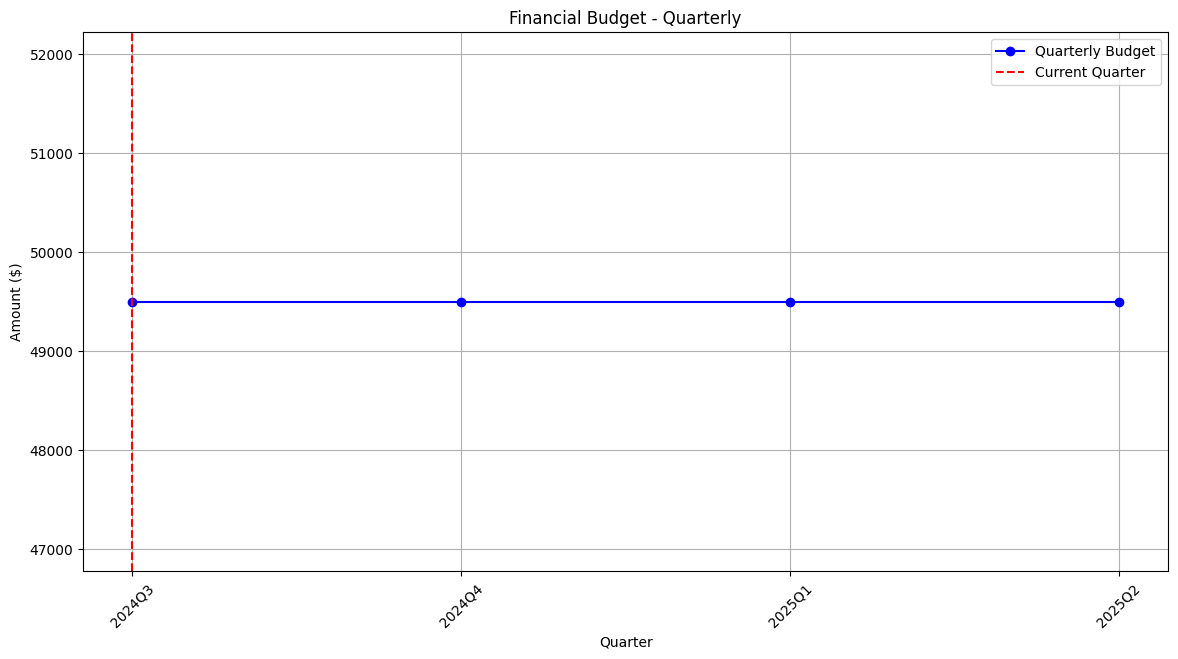

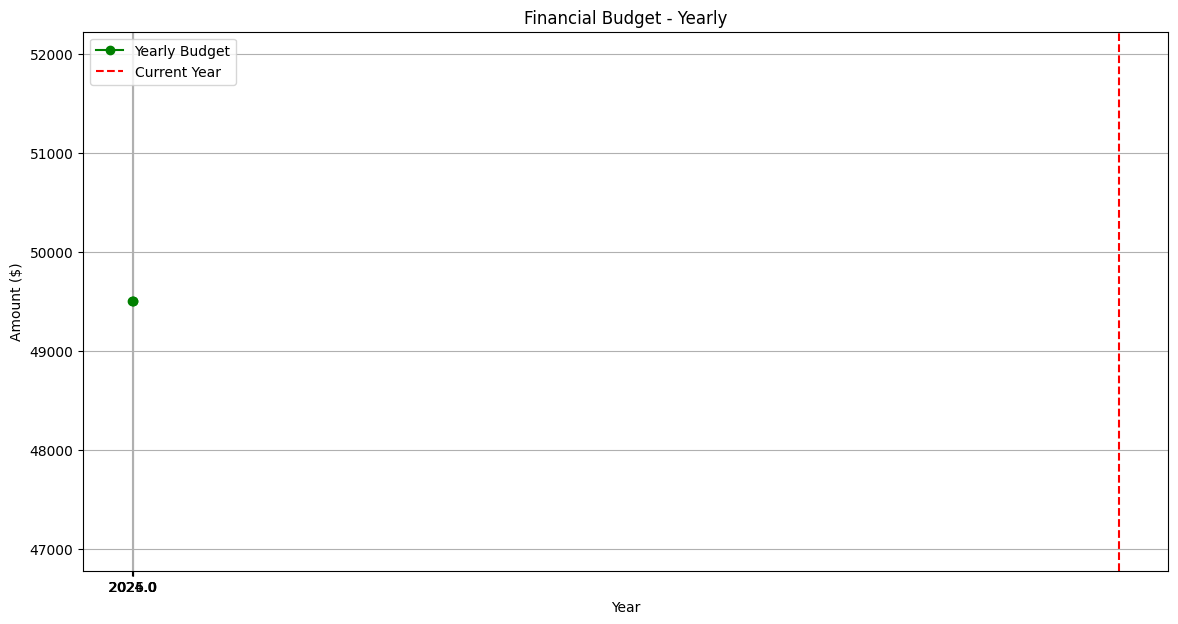

In [10]:
import matplotlib.pyplot as plt

# Combine actual and projected budgets
combined_quarterly_budget = pd.concat([quarterly_budget, projection_quarterly_df]).reset_index(drop=True)
combined_yearly_budget = pd.concat([yearly_budget, projection_yearly_df]).reset_index(drop=True)

# Plot the quarterly budget
plt.figure(figsize=(14, 7))
plt.plot(combined_quarterly_budget['quarter'].astype(str), combined_quarterly_budget['amount'], marker='o', linestyle='-', color='b', label='Quarterly Budget')
plt.axvline(x=str(current_quarter), color='r', linestyle='--', label='Current Quarter')
plt.title('Financial Budget - Quarterly')
plt.xlabel('Quarter')
plt.ylabel('Amount ($)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Plot the yearly budget
plt.figure(figsize=(14, 7))
plt.plot(combined_yearly_budget['year'].astype(str), combined_yearly_budget['amount'], marker='o', linestyle='-', color='g', label='Yearly Budget')
plt.axvline(x=current_year, color='r', linestyle='--', label='Current Year')
plt.title('Financial Budget - Yearly')
plt.xlabel('Year')
plt.ylabel('Amount ($)')
plt.legend()
plt.grid(True)
plt.show()


After running this code, we've created two important visualizations:

1. **Quarterly Budget Plot**:
   - This plot shows the budget amounts for each quarter, including both historical data and projections.
   - The blue line represents the budget amounts over time.
   - The red dashed line indicates the current quarter, separating historical data from projections.
   - This visualization allows us to see seasonal patterns and trends in quarterly budgets.

2. **Yearly Budget Plot**:
   - This plot displays the yearly budget amounts, including historical data and future projections.
   - The green line represents the budget amounts for each year.
   - The red dashed line marks the current year, distinguishing past data from future projections.
   - This visualization provides a broader view of long-term budget trends.

These visualizations offer several benefits for educational financial management:

- **Trend Identification**: We can easily spot upward or downward trends in budgets over time.
- **Seasonal Patterns**: The quarterly plot may reveal recurring patterns related to the academic calendar.
- **Projection Comparison**: We can visually compare our projections with historical trends to assess their reasonableness.
- **Budget Planning**: These visualizations can inform budget planning discussions and help in setting realistic financial goals.
- **Stakeholder Communication**: These clear, visual representations of budget data can be powerful tools for communicating financial information to stakeholders.

It's important to note that while these visualizations provide valuable insights, they should be interpreted in conjunction with other relevant information, such as changes in student enrollment, new programs, or external economic factors.

In the next section, we'll discuss how to use these visualizations and the underlying blockchain data to make informed financial decisions for the educational institution.

## Retrieving and Ordering Blockchain Data

In this section, we'll retrieve our blockchain data from Delta Lake and order it chronologically. This step is crucial for maintaining the integrity of our blockchain and preparing the data for further analysis.

Here's what we're doing:

1. **Read the Blockchain Data**:
   We use Spark to read our blockchain data from the Delta Lake table. Delta Lake ensures that we're working with the most up-to-date and consistent version of our data.

2. **Order the Data**:
   We sort the blockchain by the 'index' field. This step is vital because:
   - It maintains the chronological order of transactions, which is a fundamental property of blockchains.
   - It allows us to easily track the sequence of transactions and verify the chain's integrity.
   - It prepares the data for time-based analyses and visualizations.

By organizing our data this way, we're setting the stage for more complex analyses and ensuring that we're working with a properly structured blockchain.

Let's look at the code to accomplish this:

### Principle Used to Detect Anomaly

In the context of this example, anomaly detection is based on statistical methods, specifically the Z-score method. The Z-score measures how many standard deviations a data point is from the mean of the data set. Here’s a breakdown of the process:

1. **Calculate Mean and Standard Deviation**: Determine the average transaction amount and the standard deviation of the transaction amounts.
2. **Compute Z-Score**: For each transaction, calculate the Z-score using the formula:

  ![Z-score Equation](https://www.gstatic.com/education/formulas2/553212783/en/z_score.svg)

where \(X\) is the transaction amount, (μ) is the mean transaction amount, and (σ) is the standard deviation.

3. **Identify Anomalies**: Transactions with a Z-score greater than 3 or less than -3 are considered anomalies. This threshold is based on the empirical rule (68-95-99.7 rule), where nearly all data points lie within three standard deviations of the mean in a normal distribution.





In [11]:
# Read the blockchain ordered by index
blockchain_df = spark.read.format("delta").load("/tmp/delta/blockchain")
ordered_blockchain_df = blockchain_df.orderBy("index")


After running this code, we've accomplished two important tasks:

1. **Data Retrieval**:
   - We've successfully read the entire blockchain from our Delta Lake storage.
   - This ensures we're working with the complete and most current version of our blockchain.

2. **Chronological Ordering**:
   - By ordering the data by the 'index' field, we've maintained the crucial chronological structure of the blockchain.
   - This ordered structure allows us to:
     - Easily verify the sequence of transactions
     - Perform time-based analyses
     - Visualize the blockchain's growth over time

This ordered DataFrame (`ordered_blockchain_df`) is now ready for further processing and analysis. In the upcoming sections, we'll use this structured data to:

- Verify the integrity of our blockchain
- Analyze trends in educational spending
- Create visualizations of transaction patterns
- Derive insights to inform financial decision-making in educational contexts

By starting with this well-structured data, we're ensuring that all our subsequent analyses are based on a solid and chronologically accurate representation of our blockchain.



## Verifying Blockchain Integrity

In this section, we'll implement a crucial function to verify the integrity of our blockchain. This process is essential to ensure that our blockchain hasn't been tampered with and that each block correctly references the previous one.

Here's what our verification process does:

1. **Hash Calculation**:
   We recalculate the hash for each block using its contents. This allows us to check if the stored hash matches the calculated one.

2. **Previous Hash Verification**:
   We compare the 'previous_hash' of each block with the actual hash of the preceding block.

3. **Integrity Check**:
   We flag any discrepancies in either the calculated hash or the previous hash reference.

This verification process is crucial because:
- It ensures the immutability of our blockchain.
- It detects any unauthorized changes to historical data.
- It maintains the trustworthiness of our educational finance records.

Let's examine the code that performs this verification:

In [12]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession, Window

def verify_blockchain(df):
    # Create a window specification to access the previous row's hash
    window_spec = Window.orderBy("index")

    # Calculate the hash of each row
    df = df.withColumn(
        "calculated_hash",
        sha2(
            concat_ws(
                "||",
                col("index"),
                col("timestamp"),
                col("transactions"),
                col("amount"),
                col("previous_hash"),
                col("added_by"),
                col("category"),
                col("description")
            ),
            256
        )
    )

    # Check for integrity issues by comparing the previous hash and calculated hash
    df = df.withColumn(
        "previous_hash_check",
        F.lag("hash").over(window_spec)
    ).withColumn(
        "integrity_issue",
        (F.col("previous_hash") != F.col("previous_hash_check")) | (F.col("hash") != F.col("calculated_hash"))
    )

    # Filter rows with integrity issues
    integrity_issues = df.filter(F.col("integrity_issue"))

    return integrity_issues

integrity_issues_df = verify_blockchain(ordered_blockchain_df)
integrity_issues_df.show(truncate=False)

if integrity_issues_df.count() > 0:
    print("Integrity issues found.")
else:
    print("No integrity issues found.")


+-----+---------+------------+------+-------------+--------+--------+-----------+----+---------------+-------------------+---------------+
|index|timestamp|transactions|amount|previous_hash|added_by|category|description|hash|calculated_hash|previous_hash_check|integrity_issue|
+-----+---------+------------+------+-------------+--------+--------+-----------+----+---------------+-------------------+---------------+
+-----+---------+------------+------+-------------+--------+--------+-----------+----+---------------+-------------------+---------------+

No integrity issues found.


After running this code, we've performed a comprehensive integrity check on our blockchain. Here's what we've accomplished:

1. **Hash Recalculation**:
   We've recalculated the hash for each block based on its contents. This allows us to verify that the stored hash matches the calculated one, ensuring no block's content has been altered.

2. **Chain Continuity Check**:
   We've verified that each block correctly references the hash of the previous block, maintaining the crucial chain structure of our blockchain.

3. **Integrity Issue Detection**:
   We've identified any blocks where either the calculated hash doesn't match the stored hash, or the previous hash reference is incorrect.

4. **Results Display**:
   We've displayed any integrity issues found and printed a summary of the verification results.

The outcome of this verification process is critical:

- If no integrity issues are found, it confirms that our blockchain is intact and trustworthy.
- If any issues are detected, it alerts us to potential data tampering or corruption, allowing us to investigate and address the problem.

This integrity check is a fundamental aspect of blockchain technology, ensuring the reliability and trustworthiness of our educational finance records. Regular performance of this verification process is crucial to maintain the integrity of our blockchain-based financial system.

In the next section, we'll explore how to use this verified blockchain data for in-depth analysis of educational spending patterns and trends.

 # Visualize the anomalies

We simulate adding some fraudulent data to the blockchain that contains higher than usual amounts. We'll then use anomaly detection to identify the suspicious transactions and project the correct data for Q2 and Q3.

## Simulating Fraudulent Transactions

In this section, we'll simulate an attempt to introduce fraudulent transactions into our blockchain. This exercise is crucial for several reasons:

1. **Testing System Vulnerabilities**: It allows us to test how our system handles suspicious transactions.
2. **Demonstrating Security Importance**: It highlights the need for robust security measures in blockchain systems.
3. **Educational Purpose**: It provides a practical example of potential threats in blockchain-based financial systems.

Here's what the code does:

1. **Define Fraudulent Transactions**:
   We create a list of sample fraudulent transactions. These are designed to be clearly suspicious, with:
   - Unusually high amounts
   - Inconsistent descriptions
   - An unfamiliar user ("Bad Actor") adding the transactions

2. **Use the API to Add Transactions**:
   We use the same API endpoint that's used for legitimate transactions. This simulates a scenario where an attacker has gained access to the transaction submission system.

3. **Print API Responses**:
   We display the responses from the API to see if the transactions were accepted or rejected.

It's important to note that in a real-world scenario, we would never actually run code to add fraudulent transactions. This is purely for educational purposes to demonstrate how blockchain systems can be vulnerable if proper security measures are not in place.

Let's examine the code:

In [13]:
import requests

# API URL
api_url = "http://localhost:5001/add_block"

# Sample fraudulent transactions
fraudulent_transactions = [
    {"transactions": "Fee payment for John Doe of class 9", "amount": 150000.0, "added_by": "Bad Actor", "category": "extracurricular", "description": "Fee for after-school program for Sawaira Sajjad"},
    {"transactions": "Late-night-entertainment program", "amount": 50000.0, "added_by": "Bad Actor", "category": "extracurricular", "description": "Fee for after-school program for Malaika Khan"}
]

# Add fraudulent transactions using the API
for transaction in fraudulent_transactions:
    response = requests.post(api_url, json=transaction)
    print(response.json())


INFO:werkzeug:127.0.0.1 - - [07/Jul/2024 01:24:58] "POST /add_block HTTP/1.1" 201 -


{'message': 'Block added successfully'}


INFO:werkzeug:127.0.0.1 - - [07/Jul/2024 01:25:07] "POST /add_block HTTP/1.1" 201 -


{'message': 'Block added successfully'}


After running this code, we've simulated an attempt to add fraudulent transactions to our blockchain. Here are the key points to consider:

1. **System Response**:
   - If the API returns success messages, it indicates that our current system accepted these suspicious transactions. This highlights a potential vulnerability.
   - If the transactions were rejected, it suggests that some level of transaction validation is in place.

2. **Characteristics of the Fraudulent Transactions**:
   - Extremely high amounts (150,000 and 50,000) that are unusual for typical educational transactions
   - Suspicious descriptions (e.g., "Late-night-entertainment program")
   - Inconsistent categorization (using "extracurricular" for what appears to be a fee payment)
   - Transactions added by an unfamiliar entity ("Bad Actor")

3. **Implications and Next Steps**:
   - This exercise demonstrates the importance of implementing robust validation and approval processes before adding transactions to the blockchain.
   - It suggests the need for additional security measures such as:
     - Transaction amount limits
     - Whitelisting of approved users for transaction submission
     - AI-based anomaly detection systems
     - Multi-signature approval for large transactions
   - We should now run our blockchain verification process to see if it can detect these anomalies.

4. **Learning Opportunity**:
   - This simulation provides a tangible example of how blockchain systems can be vulnerable to fraud if proper safeguards are not in place.
   - It emphasizes the need for continuous monitoring and improvement of security measures in blockchain-based financial systems.

In the next section, we'll run our integrity check again and discuss strategies for preventing and detecting such fraudulent activities in real-world applications of blockchain in educational finance management to detect anomalies, and visualize the results.

## Detecting and Analyzing Anomalies in Blockchain Transactions

In this section, we'll implement an anomaly detection system for our blockchain transactions. This is a crucial step in identifying potential fraudulent activities or unusual patterns in our educational finance data.

Here's what our code will do:

1. **Anomaly Detection using Z-score**:
   - We'll calculate the Z-score for each transaction amount.
   - Transactions with a Z-score greater than 3 or less than -3 (three standard deviations from the mean) will be flagged as anomalies.

2. **Identifying Potential Anomalies**:
   - Once we detect an anomaly, we'll identify all other transactions from the same `added_by` user.
   - This helps us detect patterns of suspicious activity from specific users.

3. **Summarizing Anomalies**:
   - We'll print a summary of the count of anomalies and potential anomalies.
   - We'll group these by `added_by`, month, and year of the transaction.

4. **Detailed Anomaly Display**:
   - We'll show detailed information about both the detected anomalies and potential anomalies.

This process is important because:
- It helps identify unusual transactions that might indicate fraud or errors.
- It allows us to focus on specific users or time periods for further investigation.
- It provides a systematic way to monitor and maintain the integrity of our blockchain-based financial system.

Let's examine the code that performs this anomaly detection and analysis:


In [14]:
"""
Detect anomalies in the transactions using Z-score.
Once a transaction by a bad actor is identified, print potential anomalies by identifying other transactions from the same `added_by`.
Also, print a summary of the count of anomalies and potential anomalies, grouped by `added_by` within the month and year of the transaction.
"""

# Detect anomalies in the transactions
def detect_anomalies(df):
    # Calculate mean and standard deviation of the amount column
    stats = df.select(
        F.mean("amount").alias("mean_amount"),
        F.stddev("amount").alias("std_amount")
    ).collect()[0]

    mean_amount = stats["mean_amount"]
    std_amount = stats["std_amount"]

    # Calculate Z-score for each transaction
    df = df.withColumn(
        "z_score",
        (F.col("amount") - mean_amount) / std_amount
    )

    # Filter rows where Z-score is greater than 3 or less than -3
    anomalies = df.filter((F.col("z_score") > 3) | (F.col("z_score") < -3))

    return anomalies

# Call the function to detect anomalies
anomalies_df = detect_anomalies(ordered_blockchain_df)

# Check if any anomalies were detected
if anomalies_df.count() > 0:
    print("Anomalies detected.")
    # Identify other transactions from the same `added_by` as the anomalies
    bad_actor_ids = anomalies_df.select("added_by").distinct()
    potential_anomalies_df = ordered_blockchain_df.join(bad_actor_ids, on="added_by", how="inner").orderBy("index")

    # Print summary
    anomaly_count = anomalies_df.count()
    potential_anomaly_count = potential_anomalies_df.count()

    print(f"Count of anomalies: {anomaly_count}")
    print(f"Count of potential anomalies: {potential_anomaly_count}")

    # Group by `added_by` and show count within month and year of transaction
    summary_df = potential_anomalies_df.withColumn("month", F.month("timestamp")).withColumn("year", F.year("timestamp")) \
                                       .groupBy("added_by", "month", "year") \
                                       .agg(F.count("amount").alias("count"))

    print(f"Summary of anomalies")
    summary_df.show(truncate=False)

    print(f"anomalies: Total {anomalies_df.count()}")
    anomalies_df.show(truncate=False)

    # Show potential anomalies
    print(f"Potential anomalies: Total {potential_anomalies_df.count()}")
    potential_anomalies_df.show(truncate=False)


else:
    print("No anomalies detected.")


Anomalies detected.
Count of anomalies: 1
Count of potential anomalies: 2
Summary of anomalies
+---------+-----+----+-----+
|added_by |month|year|count|
+---------+-----+----+-----+
|Bad Actor|7    |2024|2    |
+---------+-----+----+-----+

anomalies: Total 1
+-----+--------------------------+-----------------------------------+--------+----------------------------------------------------------------+---------+---------------+-----------------------------------------------+----------------------------------------------------------------+----------------+
|index|timestamp                 |transactions                       |amount  |previous_hash                                                   |added_by |category       |description                                    |hash                                                            |z_score         |
+-----+--------------------------+-----------------------------------+--------+-----------------------------------------------------------

After running the above code, we've performed a comprehensive anomaly detection and analysis on our blockchain transactions. Here's what we accomplished and learned:

1. **Anomaly Detection**:
   - We used the Z-score method to identify transactions that significantly deviate from the norm.
   - This statistical approach helps us spot unusual transaction amounts that might indicate fraud or errors.

2. **Potential Anomaly Identification**:
   - By flagging all transactions from users associated with anomalies, we've cast a wider net to catch potentially suspicious activities.
   - This approach helps identify patterns of behavior rather than just isolated incidents.

3. **Summary Statistics**:
   - We now have a clear count of both direct anomalies and potential anomalies.
   - The grouping by user, month, and year helps us understand the temporal and user-specific patterns of these anomalies.

4. **Detailed Display**:
   - By showing the full details of anomalous and potentially anomalous transactions, we've provided rich context for further investigation.

Key Takeaways:
- If anomalies were detected, it suggests that our blockchain contains transactions that deviate significantly from the norm. This could indicate fraudulent activity, data entry errors, or legitimate but unusual transactions.
- If no anomalies were detected, it might mean our transactions are consistent, or it could suggest that our threshold for anomalies (3 standard deviations) might need adjustment.
- The presence of potential anomalies from the same users as anomalous transactions helps us identify patterns of suspicious behavior.

Next Steps:
1. Investigate the flagged transactions in detail to determine if they are truly fraudulent or just unusual but legitimate.
2. Consider implementing real-time anomaly detection to flag suspicious transactions before they're added to the blockchain.
3. Use this analysis to refine our transaction approval processes and potentially implement additional security measures.

This anomaly detection system demonstrates how we can use data analysis techniques to enhance the security and integrity of our blockchain-based educational finance system.


# How Blockchain Helped

The blockchain’s inherent properties enhance the anomaly detection process:

- **Immutability**: Once a transaction is recorded in a blockchain, it cannot be altered or deleted. This ensures the integrity and reliability of the transaction history, making it easier to trust the data used for anomaly detection.
- **Transparency**: Every transaction is recorded in a public or permissioned ledger, which allows for complete transparency. This makes it easier to audit transactions and spot any suspicious activity.
- **Traceability**: Blockchain records the entire history of transactions, which helps in tracking and verifying the origin and flow of transactions.

# Delta Lake vs. Ethereum-Based Blockchain

## Delta Lake Blockchain

**Pros**:

- **Performance**: Delta Lake, built on top of Apache Spark, offers high performance for big data analytics and can handle large volumes of data efficiently.
- **Cost-Effective**: Running Delta Lake on existing infrastructure (e.g., on-premises or cloud storage) can be more cost-effective than using a public blockchain network.
- **Flexibility**: Delta Lake integrates well with various big data tools and frameworks, providing flexibility in data processing and analytics.
- **Scalability**: Delta Lake can scale horizontally to handle increasing data loads, making it suitable for large datasets.

**Cons**:

- **Centralization**: Unlike public blockchains, Delta Lake is typically deployed in a centralized or semi-centralized environment, which may not provide the same level of decentralization and trustlessness.
- **Security**: Being centralized or semi-centralized, it may be more susceptible to single points of failure or attacks compared to a decentralized blockchain.
- **Limited Smart Contracts**: Delta Lake does not inherently support smart contracts, which limits its use cases compared to Ethereum.

## Ethereum-Based Blockchain

**Pros**:

- **Decentralization**: Ethereum is a decentralized blockchain network, which means no single entity controls the network, enhancing security and trust.
- **Smart Contracts**: Ethereum supports smart contracts, which are self-executing contracts with the terms of the agreement directly written into code. This enables complex, automated interactions between parties.
- **Security**: Ethereum's consensus mechanisms (e.g., Proof of Stake) and decentralization enhance security against attacks.
- **Transparency and Immutability**: Ethereum provides high transparency and immutability, which is critical for applications requiring trust and auditability.

**Cons**:

- **Cost**: Transactions on Ethereum require gas fees, which can be expensive, especially during network congestion.
- **Performance**: Ethereum's transaction throughput is limited compared to traditional databases and big data systems, potentially leading to slower transaction times.
- **Scalability**: Despite ongoing improvements, Ethereum faces scalability challenges, making it less suitable for applications requiring high transaction volumes.

# Conclusion

The choice between a Delta Lake-based blockchain and an Ethereum-based blockchain depends on the specific use case requirements. Delta Lake may be more suitable for applications focused on large-scale data analytics and cost-efficiency, while Ethereum provides robust decentralization, security, and smart contract capabilities for applications requiring high trust and automation.